# Titanic passenger survival prediction (top 12% in Kaggle competition)

The task for this notebook is a binary classification problem where one has to build a machine learning model to predict whether a passenger survived the famous Titanic shipwreck.

The data set for this task was taken from a Kaggle competition: https://www.kaggle.com/c/titanic. I have participated in the competition and my rank is top 12% of the candidates out of ~17,000 competition participants.

The notebook explores the Titanic data set and uses various algorithms for the classification including:
1. Logistic Regression
2. Support Vector Machines
3. Random Forest
4. Gradient Boosting
5. Stacked models which combine predictions from various individual models

# Setting up the environment

In [72]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix

import xgboost


%matplotlib inline

# Reading the train and test data sets

1. Train data: Used for training the binary classifiers to build a model that could predict whether a passenger survived
2. Test data: This data is used to generate predictions on an independent data set that was not use in training and these predictions are then submitted to the Kaggle platform to evaluate the performance of the models.

In [2]:
# Read the train and test data and combine them into
# one Pandas DataFrame to do the data preprocessing
train = pd.read_csv('./dataset/train.csv')
test = pd.read_csv('./dataset/test.csv')

In [3]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [5]:
# Combine the train and test data
comb = pd.concat([train, test])
comb.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


#### Check for NULL values in the combined DataFrame
Looks like there are some missing or NULL values in the <code>Age</code>, <code>Cabin</code> and <code>Embarked</code> columns. A method has to be found to deal with these missing values (done later).

In [6]:
comb.isnull().sum()

PassengerId       0
Survived        418
Pclass            0
Name              0
Sex               0
Age             263
SibSp             0
Parch             0
Ticket            0
Fare              1
Cabin          1014
Embarked          2
dtype: int64

# Data Exploration and Feature Engineering

In this section we will explore the dimensions of the data set and drop some of the non-important features for predicting the survival (for example, the <code>Name</code> column since every passenger will probably have a unique name and this information does not help us to understand whether this person will survive or not).

We will also generate some new features that improves our predictive power

In [7]:
# Drop the Name, Ticket and Cabin Columns
train2=train.drop(['Name', 'Ticket', 'Cabin'], axis=1)
test2=test.drop(['Name', 'Ticket', 'Cabin'], axis=1)
comb=pd.concat([train2, test2])
comb.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,1,0.0,3,male,22.0,1,0,7.2500,S
1,2,1.0,1,female,38.0,1,0,71.2833,C
2,3,1.0,3,female,26.0,0,0,7.9250,S
3,4,1.0,1,female,35.0,1,0,53.1000,S
4,5,0.0,3,male,35.0,0,0,8.0500,S


#### Multivariate Analysis

We now check the effect of the individual features on the <code>Survived</code> Column

##### <code>PClass</code>
 
Looks like many of the upper class passengers survived. Probably because the life boats were preferentially served to them first

In [8]:
train2.groupby(['Pclass'], as_index=False)['Survived'].mean()

,Pclass,Survived
0,1,0.629630
1,2,0.472826
2,3,0.242363


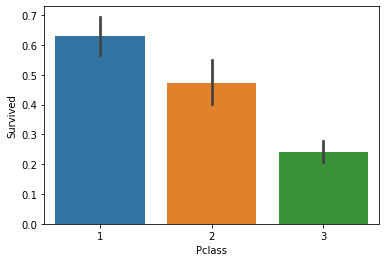

In [9]:
sns.barplot(x='Pclass', y='Survived', data=train2)

##### <code>Sex</code>
Looks like the survival probablity is more for females than males.

In [10]:
train2.groupby(['Sex'], as_index=False)['Survived'].mean()

,Sex,Survived
0,female,0.742038
1,male,0.188908


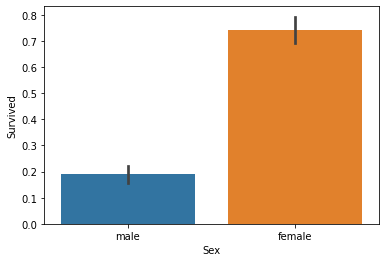

In [11]:
sns.barplot(x='Sex', y='Survived', data=train2)

##### <code>PClass</code> and <code>Sex</code>

The trend is clear:

Upper class passengers who are women have the highest probability of survival.

Lower class passengers who are male have the lowest probability to survive. Poor them!

In [12]:
train2.groupby(['Pclass', 'Sex'], as_index=False)['Survived'].mean()

,Pclass,Sex,Survived
0,1,female,0.968085
1,1,male,0.368852
2,2,female,0.921053
3,2,male,0.157407
4,3,female,0.500000
5,3,male,0.135447


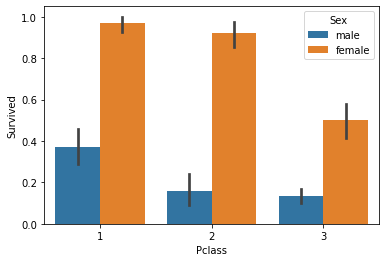

In [13]:
sns.barplot(x='Pclass', y='Survived', hue='Sex', data=train2)

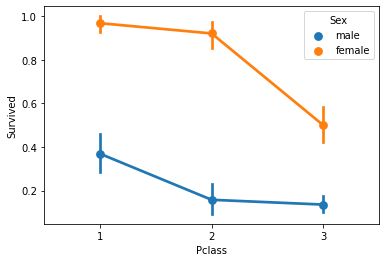

In [14]:
sns.pointplot(x='Pclass', y='Survived', hue='Sex', data=train2)

##### <code>PClass</code>, <code>Sex</code> and <code>Embarked</code>

We additionally check the effect of the ##### <code>Embarked</code> column in combination with <code>PClass</code> and <code>Sex</code>. Looks like the <code>Embarked</code> column has no significant effect to the survival probability

/Users/apple/miniconda3/envs/cta-dev/lib/python3.8/site-packages/seaborn/axisgrid.py:728: UserWarning: Using the pointplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)
/Users/apple/miniconda3/envs/cta-dev/lib/python3.8/site-packages/seaborn/axisgrid.py:733: UserWarning: Using the pointplot function without specifying `hue_order` is likely to produce an incorrect plot.
  warnings.warn(warning)


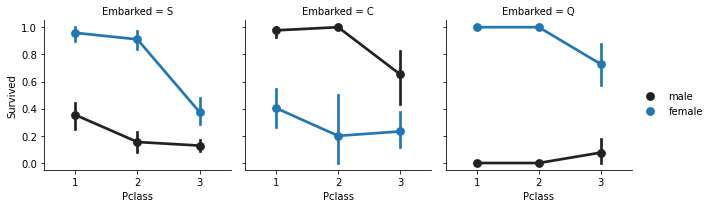

In [15]:
g=sns.FacetGrid(train2, col='Embarked')
g.map(sns.pointplot, 'Pclass', 'Survived', 'Sex')
g.add_legend()

#### <code>SibSp</code>

We investigate whether having a Sibling or a Spouse (the <code>SibSp</code> column) increases the survival probability.

Looks like a Sibling or Spouse have a higher degree of survival across all classes except the lowest class (PClass==3).

/Users/apple/miniconda3/envs/cta-dev/lib/python3.8/site-packages/seaborn/axisgrid.py:728: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


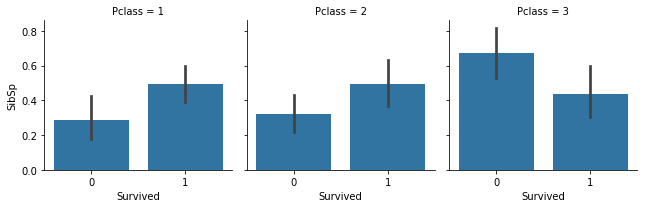

In [16]:
g=sns.FacetGrid(train2, col='Pclass', )
g.map(sns.barplot, 'Survived', 'SibSp')
g.add_legend()

##### <code>Fare</code>

The result is quite intuitive : The Class 1 passengers pay the highest fare compared to Class 2 and 3 (women in Class 1 paid slightly more than the men)

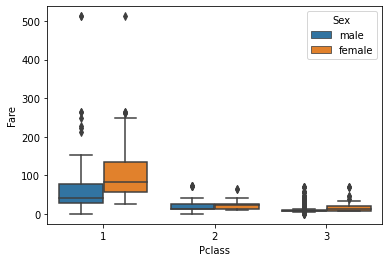

In [17]:
sns.boxplot(x='Pclass', y='Fare', hue='Sex', data=train2)

In [18]:
train2.Fare.mean()

32.204207968574636

In [19]:
train2.Fare.median()

14.4542

In [20]:
train2.Fare.max()

512.3292

In [21]:
train2.Fare.min()

0.0

#### <code>FareBand</code>

We create a new feature called <code>Fareband</code>

In [22]:
# We now divide the data into 5 fare bands and check the survival probability in each of them
train2['FareBand']=pd.qcut(train2['Fare'], 4)
train2[['Fare', 'FareBand']].head()

,Fare,FareBand
0,7.2500,"(-0.001, 7.91]"
1,71.2833,"(31.0, 512.329]"
2,7.9250,"(7.91, 14.454]"
3,53.1000,"(31.0, 512.329]"
4,8.0500,"(7.91, 14.454]"


In [23]:
fare_survival = train2.groupby(['FareBand'], as_index=False)['Survived'].mean().sort_values(by='Survived')
fare_survival.head()

,FareBand,Survived
0,"(-0.001, 7.91]",0.197309
1,"(7.91, 14.454]",0.303571
2,"(14.454, 31.0]",0.454955
3,"(31.0, 512.329]",0.581081


Looks like passengers who paid the highest amount of fare have the highest probability to survive. This goes in agreement with the <code>PClass</code> feature i.e. higher class means more fare which in turns reflects higher survival rate.

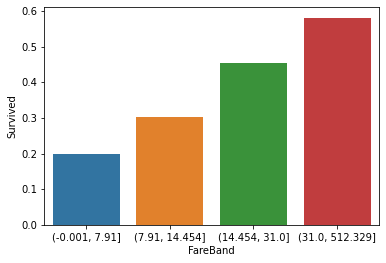

In [24]:
sns.barplot(x='FareBand', y='Survived', data=fare_survival)

#### Imputing missing values

In [25]:
imputer = SimpleImputer(strategy='mean')

imputer_mostfreq = SimpleImputer(strategy='most_frequent')

train2[['Age', 'Fare']] = imputer.fit_transform(train2[['Age', 'Fare']])
test2[['Age', 'Fare']] = imputer.fit_transform(test2[['Age', 'Fare']])

train2[['Embarked']] = imputer_mostfreq.fit_transform(train2[['Embarked']])
test2[['Embarked']] = imputer_mostfreq.fit_transform(test2[['Embarked']])

comb = pd.concat([train2, test2])

In [26]:
comb.isnull().sum()

PassengerId      0
Survived       418
Pclass           0
Sex              0
Age              0
SibSp            0
Parch            0
Fare             0
Embarked         0
FareBand       418
dtype: int64

#### Fare encoder
We encode the different fare bands and delete the <code>Fare</code> feature as the fare bands give a better prediction of the model to see whether the person survived.

In [27]:
def fare_categorizer(fare):
    if fare<7.91:
        return 1
    elif fare>7.91 and fare<14.454:
        return 2
    elif fare > 14.454 and fare<31.0:
        return 3
    else:
        return 4


train2['NewFare'] = train2['Fare'].apply(fare_categorizer)
test2['NewFare'] = test2['Fare'].apply(fare_categorizer)

print(train2[['Fare', 'NewFare']].tail())

train3 = train2.drop(['Fare', 'FareBand'], axis=1)
test3 = test2.drop(['Fare'], axis=1)

comb=pd.concat([train3, test3])

      Fare  NewFare
886  13.00        2
887  30.00        3
888  23.45        3
889  30.00        3
890   7.75        1


In [28]:
train3.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch',
       'Embarked', 'NewFare'],
      dtype='object')

In [29]:
test3.columns

Index(['PassengerId', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Embarked',
       'NewFare'],
      dtype='object')

#### <code>Age</code>
 Looks like individual ages have no good predictive power of the survival of a passenger.
 
 Hence we will divide the data into different Age groups and check whether a particular Age group has better survival probability compared to others.

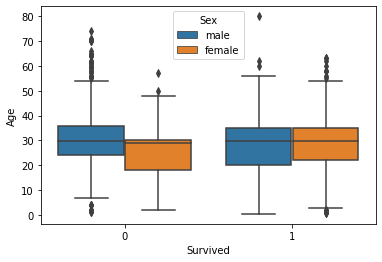

In [30]:
sns.boxplot(x='Survived', y='Age', hue='Sex', data=train3)

In [31]:
train3['AgeGroup'] = pd.cut(train3['Age'], 5)
#train['AgeGroup'].unique()

In [32]:
pd.cut(train3['Age'], 5)

0      (16.336, 32.252]
1      (32.252, 48.168]
2      (16.336, 32.252]
3      (32.252, 48.168]
4      (32.252, 48.168]
             ...       
886    (16.336, 32.252]
887    (16.336, 32.252]
888    (16.336, 32.252]
889    (16.336, 32.252]
890    (16.336, 32.252]
Name: Age, Length: 891, dtype: category
Categories (5, interval[float64]): [(0.34, 16.336] < (16.336, 32.252] < (32.252, 48.168] < (48.168, 64.084] < (64.084, 80.0]]

In [33]:
train3.groupby(['AgeGroup'], as_index=False)['Survived'].mean().sort_values(by='Survived')

,AgeGroup,Survived
4,"(64.084, 80.0]",0.090909
1,"(16.336, 32.252]",0.344168
2,"(32.252, 48.168]",0.404255
3,"(48.168, 64.084]",0.434783
0,"(0.34, 16.336]",0.550000


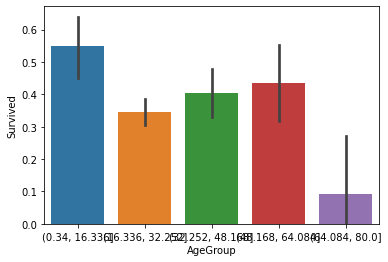

In [34]:
sns.barplot(x='AgeGroup', y='Survived', data=train3)

In [35]:
def age_categorizer(age):
    if age<16.33:
        return 1
    if age>16.33 and age<32.252:
        return 2
    if age > 32.252 and age<48.168:
        return 3
    if age>48.168 and age<64.08:
        return 4
    else:
        return 5
    

age_categorizer(5.0)

1

In [36]:
train3['NewAge'] = train3['Age'].apply(age_categorizer)
test3['NewAge'] = test3['Age'].apply(age_categorizer)

print(train3[['Age', 'NewAge']].tail())

train4 = train3.drop(['Age', 'AgeGroup'], axis=1)
test4 = test3.drop(['Age'], axis=1)

comb = pd.concat([train4, test4])

           Age  NewAge
886  27.000000       2
887  19.000000       2
888  29.699118       2
889  26.000000       2
890  32.000000       2


#### Categorical encoder for the <code>Sex</code>

The <code>Sex</code> column is categorical.

We will encode it using <code>LabelEncoder</code> to convert it to an integer.

In [37]:
le = LabelEncoder()

train4['NewSex'] = le.fit_transform(train4[['Sex']])
test4['NewSex'] = le.fit_transform(test4[['Sex']])

train5 = train4.drop(['Sex'], axis=1)
test5 = test4.drop(['Sex'], axis=1)

comb = pd.concat([train5, test5])
comb.head()

/Users/apple/miniconda3/envs/cta-dev/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:251: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


,PassengerId,Survived,Pclass,SibSp,Parch,Embarked,NewFare,NewAge,NewSex
0,1,0.0,3,1,0,S,1,2,1
1,2,1.0,1,1,0,C,4,3,0
2,3,1.0,3,0,0,S,2,2,0
3,4,1.0,1,1,0,S,4,3,0
4,5,0.0,3,0,0,S,2,3,1


#### Categorical encoder for the <code>Embarked</code>

The <code>Embarked</code> column is categorical.

We will encode it using <code>LabelEncoder</code> to convert it to an integer.

In [38]:
train5 = pd.get_dummies(train5, columns=['Embarked'], drop_first=True, prefix='Embarked_')
test5 = pd.get_dummies(test5, columns=['Embarked'], drop_first=True, prefix='Embarked_')

comb = pd.concat([train5, test5])

comb.head()

,PassengerId,Survived,Pclass,SibSp,Parch,NewFare,NewAge,NewSex,Embarked__Q,Embarked__S
0,1,0.0,3,1,0,1,2,1,0,1
1,2,1.0,1,1,0,4,3,0,0,0
2,3,1.0,3,0,0,2,2,0,0,1
3,4,1.0,1,1,0,4,3,0,0,1
4,5,0.0,3,0,0,2,3,1,0,1


In [39]:
comb.groupby(['SibSp'], as_index=False)['Survived'].mean().sort_values(by='Survived')

,SibSp,Survived
5,5,0.000000
6,8,0.000000
4,4,0.166667
3,3,0.250000
0,0,0.345395
2,2,0.464286
1,1,0.535885


#### categorical encoding of the <code>Parch</code> and <code>SibSp</code> columns

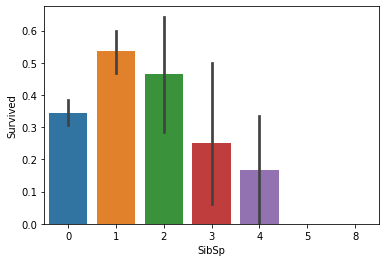

In [40]:
sns.barplot(y='Survived', x='SibSp', data=comb)

In [41]:
comb.groupby(['Parch'], as_index=False)['Survived'].mean().sort_values(by='Survived')

,Parch,Survived
4,4,0.000000
6,6,0.000000
5,5,0.200000
0,0,0.343658
2,2,0.500000
1,1,0.550847
3,3,0.600000
7,9,NaN


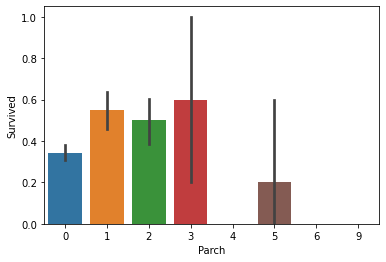

In [42]:
sns.barplot(y='Survived', x='Parch', data=comb)

In [43]:
comb.head()

,PassengerId,Survived,Pclass,SibSp,Parch,NewFare,NewAge,NewSex,Embarked__Q,Embarked__S
0,1,0.0,3,1,0,1,2,1,0,1
1,2,1.0,1,1,0,4,3,0,0,0
2,3,1.0,3,0,0,2,2,0,0,1
3,4,1.0,1,1,0,4,3,0,0,1
4,5,0.0,3,0,0,2,3,1,0,1


In [44]:
comb = pd.get_dummies(comb, columns=['SibSp', 'Parch'], drop_first=True)
comb.head()

,PassengerId,Survived,Pclass,NewFare,NewAge,NewSex,Embarked__Q,Embarked__S,SibSp_1,SibSp_2,...,SibSp_4,SibSp_5,SibSp_8,Parch_1,Parch_2,Parch_3,Parch_4,Parch_5,Parch_6,Parch_9
0,1,0.0,3,1,2,1,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0
1,2,1.0,1,4,3,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2,3,1.0,3,2,2,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,1.0,1,4,3,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0
4,5,0.0,3,2,3,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


#### Seperetaing the train and test data sets after data preprocessing

In [45]:
train6 = comb.loc[comb['PassengerId'].isin(train5['PassengerId'])]
test6 = comb.loc[comb['PassengerId'].isin(test5['PassengerId'])]

print(test6.head())

   PassengerId  Survived  Pclass  NewFare  NewAge  NewSex  Embarked__Q  \
0          892       NaN       3        1       3       1            1   
1          893       NaN       3        1       3       0            0   
2          894       NaN       2        2       4       1            1   
3          895       NaN       3        2       2       1            0   
4          896       NaN       3        2       2       0            0   

   Embarked__S  SibSp_1  SibSp_2  ...  SibSp_4  SibSp_5  SibSp_8  Parch_1  \
0            0        0        0  ...        0        0        0        0   
1            1        1        0  ...        0        0        0        0   
2            0        0        0  ...        0        0        0        0   
3            1        0        0  ...        0        0        0        0   
4            1        1        0  ...        0        0        0        1   

   Parch_2  Parch_3  Parch_4  Parch_5  Parch_6  Parch_9  
0        0        0        0      

In [46]:
print(train6.shape, test6.shape)

(891, 21) (418, 21)


In [57]:
# After seperating out the train and test data sets we drop the <code>PassengerId</code> column
train7 = train6.drop(['PassengerId'], axis=1)
test7 = test6.drop(['PassengerId', 'Survived'], axis=1)

test7.head()

,Pclass,NewFare,NewAge,NewSex,Embarked__Q,Embarked__S,SibSp_1,SibSp_2,SibSp_3,SibSp_4,SibSp_5,SibSp_8,Parch_1,Parch_2,Parch_3,Parch_4,Parch_5,Parch_6,Parch_9
0,3,1,3,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,3,1,3,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0
2,2,2,4,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,3,2,2,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
4,3,2,2,0,0,1,1,0,0,0,0,0,1,0,0,0,0,0,0


In [58]:
print(train7.shape, test7.shape)

(891, 20) (418, 19)


# Machine Learning Classification Models

#### Splitting the data into train and validation set

The train dataset will be used to build and train the classfication model.

The test dataset will be used to validate the developed model.

In [49]:
X, y = train7.drop(['Survived'], axis=1), train7['Survived']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

## Logistic Regression

In [69]:
params = {'penalty': ['l1', 'l2'], 'C': np.logspace(-3, 3,100)}

lr = LogisticRegression(random_state=42)

gs_lr = GridSearchCV(lr, param_grid=params, scoring='accuracy', n_jobs=-1, cv=5, verbose=1)

gs_lr.fit(X_train, y_train)

print("Grid Search best score={}".format(gs_lr.best_score_))
print("Grid Search best params={}".format(gs_lr.best_params_))

pred_lr = gs_lr.predict(X_test)

print(classification_report(y_test, pred_lr))
print(confusion_matrix(y_test, pred_lr))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done 312 tasks      | elapsed:    1.2s


Grid Search best score=0.7978036048458584
Grid Search best params={'C': 1.4174741629268048, 'penalty': 'l2'}
              precision    recall  f1-score   support

         0.0       0.81      0.85      0.83       110
         1.0       0.73      0.68      0.71        69

    accuracy                           0.78       179
   macro avg       0.77      0.76      0.77       179
weighted avg       0.78      0.78      0.78       179

[[93 17]
 [22 47]]


[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    5.5s finished


## SVM

In [70]:
params = {'C': np.logspace(-3, 3, 100), 'kernel':['rbf', 'poly', 'sigmoid', 'linear']}

svm = SVC(random_state=42)

gs_svm = GridSearchCV(svm, param_grid=params, cv=5, scoring='accuracy', n_jobs=-1, verbose=1)

gs_svm.fit(X_train, y_train)

print("Grid Search best score={}".format(gs_svm.best_score_))
print("Grid Search best params={}".format(gs_svm.best_params_))

pred_svm = gs_svm.predict(X_test)

print(classification_report(y_test, pred_svm))
print(confusion_matrix(y_test, pred_svm))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 400 candidates, totalling 2000 fits


[Parallel(n_jobs=-1)]: Done 200 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 1400 tasks      | elapsed:   11.4s


Grid Search best score=0.8216980202895694
Grid Search best params={'C': 11.497569953977356, 'kernel': 'rbf'}
              precision    recall  f1-score   support

         0.0       0.81      0.92      0.86       110
         1.0       0.83      0.65      0.73        69

    accuracy                           0.82       179
   macro avg       0.82      0.79      0.80       179
weighted avg       0.82      0.82      0.81       179

[[101   9]
 [ 24  45]]


[Parallel(n_jobs=-1)]: Done 2000 out of 2000 | elapsed:   38.1s finished


## Random Forest

In [71]:
params = {'n_estimators':np.arange(10, 500, 10), 'max_depth':[2,3,4,5, 6], 'min_samples_leaf':[2,3,4,5, 6]}

rf = RandomForestClassifier(random_state=42)

gs_rf = GridSearchCV(rf, param_grid=params, cv=5, scoring='accuracy', n_jobs=-1, verbose=1)

gs_rf.fit(X_train, y_train)

print("Grid Search best score={}".format(gs_rf.best_score_))
print("Grid Search best params={}".format(gs_rf.best_params_))

pred_rf = gs_rf.predict(X_test)

print(classification_report(y_test, pred_rf))
print(confusion_matrix(y_test, pred_rf))

Fitting 5 folds for each of 1225 candidates, totalling 6125 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    5.9s
[Parallel(n_jobs=-1)]: Done 240 tasks      | elapsed:   51.2s
[Parallel(n_jobs=-1)]: Done 490 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 840 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 1290 tasks      | elapsed:  4.5min
[Parallel(n_jobs=-1)]: Done 1840 tasks      | elapsed:  6.4min
[Parallel(n_jobs=-1)]: Done 2490 tasks      | elapsed:  8.8min
[Parallel(n_jobs=-1)]: Done 3240 tasks      | elapsed: 20.4min
[Parallel(n_jobs=-1)]: Done 4090 tasks      | elapsed: 23.6min
[Parallel(n_jobs=-1)]: Done 5040 tasks      | elapsed: 27.1min
[Parallel(n_jobs=-1)]: Done 6090 tasks      | elapsed: 31.4min


Grid Search best score=0.823116320299419
Grid Search best params={'max_depth': 4, 'min_samples_leaf': 2, 'n_estimators': 60}
              precision    recall  f1-score   support

         0.0       0.79      0.94      0.85       110
         1.0       0.85      0.59      0.70        69

    accuracy                           0.80       179
   macro avg       0.82      0.77      0.78       179
weighted avg       0.81      0.80      0.80       179

[[103   7]
 [ 28  41]]


[Parallel(n_jobs=-1)]: Done 6125 out of 6125 | elapsed: 31.7min finished


## Gradient Boosting

In [75]:
xgbcls = xgboost.XGBClassifier(random_state=42, objective='reg:logistic', booster='gbtree', n_jobs=-1)

params = {'n_estimators': [10, 50, 100, 500], 
          'max_depth': np.arange(2,6), 
          'learning_rate': [0.001, 0.01, 0.1], 
          'gamma' : [0.01, 0.1, 0.5], 
          'subsample': np.arange(0.7, 1.1, 0.1), 
          'colsample_bytree': np.arange(0.7, 1.1, 0.1), 
          'reg_alpha': np.logspace(-3, 3, 6), 
          'reg_lambda': np.logspace(-3, 3, 6)}

gs_xgb = GridSearchCV(xgbcls, param_grid=params, scoring='accuracy', cv=5, n_jobs=-1, verbose=1)

gs_xgb.fit(X_train, y_train)

print("Grid Search best score={}".format(gs_xgb.best_score_))
print("Grid Search best params={}".format(gs_xgb.best_params_))

pred_xgb = gs_xgb.predict(X_test)

print(classification_report(y_test, pred_xgb))
print(confusion_matrix(y_test, pred_xgb))

Fitting 5 folds for each of 129600 candidates, totalling 648000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    6.2s
[Parallel(n_jobs=-1)]: Done 2292 tasks      | elapsed:   25.8s
[Parallel(n_jobs=-1)]: Done 2894 tasks      | elapsed:   45.2s
[Parallel(n_jobs=-1)]: Done 3244 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 4652 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 6596 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 7544 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done 10308 tasks      | elapsed:  4.6min
[Parallel(n_jobs=-1)]: Done 13228 tasks      | elapsed:  5.7min
[Parallel(n_jobs=-1)]: Done 14428 tasks      | elapsed:  7.2min
[Parallel(n_jobs=-1)]: Done 17990 tasks      | elapsed:  8.7min
[Parallel(n_jobs=-1)]: Done 21492 tasks      | elapsed: 10.3min
[Parallel(n_jobs=-1)]: Done 25066 tasks      | elapsed: 18.9min
[Parallel(n_jobs=-1)]: Done 28728 tasks      | elapsed: 21.1min
[Parallel(n_jobs=-1)]: Done 34504 ta

Grid Search best score=0.8273219738008472
Grid Search best params={'colsample_bytree': 0.8999999999999999, 'gamma': 0.01, 'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 50, 'reg_alpha': 0.001, 'reg_lambda': 0.25118864315095796, 'subsample': 0.7}
              precision    recall  f1-score   support

         0.0       0.78      0.93      0.85       110
         1.0       0.83      0.58      0.68        69

    accuracy                           0.79       179
   macro avg       0.81      0.75      0.77       179
weighted avg       0.80      0.79      0.78       179

[[102   8]
 [ 29  40]]


## Voting Classifier

We aggregate the predictions of individual models and build a metamodel that combines a weighted prediction from all of them (Logistic Regression has been ignored due to poor performance compared to other models). The stacked Voting Clasifiers perform better than each individual classifier.

In [77]:
#rf = RandomForestClassifier(max_depth= 4, min_samples_leaf= 2, n_estimators= 50, random_state=42)
#svm = SVC(C= 10, kernel= 'rbf', random_state=42)

lr_vc = gs_lr.best_estimator_
rf_vc = gs_rf.best_estimator_
svm_vc = gs_svm.best_estimator_
xgb_vc = gs_xgb.best_estimator_


classifiers = [('rf_vc', rf_vc), ('svm_vc', svm_vc), ('xgb_vc', xgb_vc)]

vc = VotingClassifier(classifiers)

cval_vc = cross_val_score(vc, X_train, y_train, cv=5, scoring='accuracy', n_jobs=-1, verbose=1)

print("VotingClass cross-validation={}".format(cval_vc.mean()))

#### Prediction accuracy
vc.fit(X_train, y_train)
pred_vc = vc.predict(X_test)

print(classification_report(y_test, pred_vc))
print(confusion_matrix(y_test, pred_vc))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


VotingClass cross-validation=0.8287205751994484
              precision    recall  f1-score   support

         0.0       0.78      0.95      0.86       110
         1.0       0.87      0.58      0.70        69

    accuracy                           0.80       179
   macro avg       0.83      0.76      0.78       179
weighted avg       0.82      0.80      0.79       179

[[104   6]
 [ 29  40]]


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.5s finished


# Submission

In [78]:
test7.shape

(418, 19)

In [79]:
test7.head()

,Pclass,NewFare,NewAge,NewSex,Embarked__Q,Embarked__S,SibSp_1,SibSp_2,SibSp_3,SibSp_4,SibSp_5,SibSp_8,Parch_1,Parch_2,Parch_3,Parch_4,Parch_5,Parch_6,Parch_9
0,3,1,3,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,3,1,3,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0
2,2,2,4,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,3,2,2,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
4,3,2,2,0,0,1,1,0,0,0,0,0,1,0,0,0,0,0,0


In [84]:
final_predictions = vc.predict(test7)

output = pd.DataFrame({'PassengerId':test6.PassengerId, 'Survived':final_predictions})

output['PassengerId'] = output['PassengerId'].astype(int)

output.to_csv('wriju_submission_votingcls.csv', index=False)
print("Your submission was successfully saved!")

Your submission was successfully saved!
